# MeanShift Clustering

**MeanShift Clustering** is a classic **density-based** clustering method that finds clusters by locating **modes** (local density peaks) in your data.

**How it works (big picture):**
- Think of your data as scattered points sampled from an unknown probability distribution.
- MeanShift places a **kernel window** (like a Gaussian) around each point to estimate the local density.
- It then **shifts** each point toward the region of highest local density — *the local mean* — and repeats this process.
- Points that converge to the same **density peak** (mode) are grouped together in the same cluster.

**Key strength:**  
- You **don’t need to set the number of clusters** in advance — it’s inferred automatically from the number of detected density peaks.
- Instead, you set the "bandwidth" (size) of the kernel

**Key assumption:**  
- Clusters are **regions of high point density** — so they must form clear **modes** (peaks) in the density estimate.
- This means clusters should be somewhat **compact and blob-like** — distinct dense clouds separated by lower-density regions.

**When it struggles:**  
- MeanShift is not suited for clusters that are **hollow or manifold-shaped**, like concentric rings or spirals.
- Example: For rings, the density peak would lie *inside* the empty center, not on the ring itself.
- The shifting process would collapse points inward, merging them incorrectly.

**Best use cases:**  
- Small to medium datasets (it is slower than most other methods).
- Automatic discovery of an unknown number of clusters.
- Situations where clusters are naturally compact and well-separated by low-density gaps.

**Bottom line:**  
MeanShift is powerful for **automatic mode finding**, but its results depend heavily on:
- The **bandwidth** (kernel size).
- The true shape of your clusters matching the **“peak = cluster”** assumption.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

# Make data

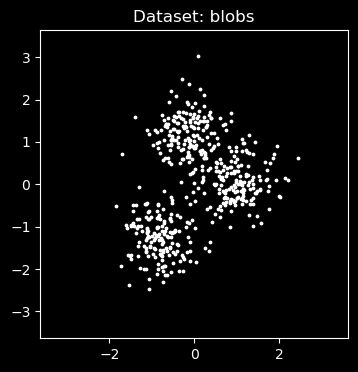

In [2]:
from sklearn.datasets import make_blobs, make_classification, make_moons, make_circles

dataset_type = 'blobs'  # try: blobs, classification, moons, circles, anisotropic, varied

if dataset_type == 'blobs':
    X1, _ = make_blobs(
        n_samples=500,
        centers=3,
        cluster_std=3,
        random_state=42
    )

elif dataset_type == 'classification':
    X1, _ = make_classification(
        n_samples=120,
        n_features=2,
        n_redundant=0,
        n_clusters_per_class=1,
        n_classes=3,
        class_sep=2,
        random_state=42
    )

elif dataset_type == 'moons':
    from sklearn.datasets import make_moons
    X1, _ = make_moons(
        n_samples=120,
        noise=0.1,
        random_state=42
    )

elif dataset_type == 'circles':
    from sklearn.datasets import make_circles
    X1, _ = make_circles(
        n_samples=500,
        noise=0.05,
        factor=0.5,
        random_state=42
    )

elif dataset_type == 'anisotropic':
    X1, _ = make_blobs(
        n_samples=120,
        centers=3,
        cluster_std=1,
        random_state=42
    )
    # Apply an anisotropic linear transformation
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X1 = X1.dot(transformation)

elif dataset_type == 'varied':
    X1, _ = make_blobs(
        n_samples=120,
        centers=[[-5, -5], [0, 0], [5, 5]],
        cluster_std=[1.0, 2.5, 0.5],
        random_state=42
    )

else:
    raise ValueError("Unknown dataset_type")

# Normalize and add optional noise
n_noise = 0
X1 -= np.mean(X1, axis=0)
MAX = np.max(np.abs(X1))
X2 = np.random.uniform(-MAX, MAX, size=(n_noise, 2))

X = np.concatenate((X1, X2), axis=0)
X -= np.mean(X, axis=0)
X /= np.std(X)
MAX = np.max(np.abs(X)) * 1.2

# Plot
%matplotlib inline

plt.figure(figsize=(4, 4))
plt.scatter(X[:, 0], X[:, 1], c='w', s=3)
plt.xlim(-MAX, MAX)
plt.ylim(-MAX, MAX)
plt.gca().set_aspect('equal')
plt.title(f"Dataset: {dataset_type}")
plt.show()

## View histogram

In [13]:
# Calculate 2D histogram
hist, xedges, yedges = np.histogram2d(X[:,0], X[:,1], bins=20)

# Construct arrays for the X-Y edges
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")

%matplotlib qt

# Create 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D surface
surf = ax.plot_surface(xpos, ypos, hist, cmap='viridis')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-MAX, MAX)
ax.set_ylim(-MAX, MAX)
ax.set_zlabel('Frequency')
ax.set_title('2D Histogram')

# Add color bar
fig.colorbar(surf)

plt.show()

## 1D KDE example

In [10]:
from matplotlib.animation import FuncAnimation
from scipy.stats import gaussian_kde

# Generate random 1D data
np.random.seed(0)
X2 = np.concatenate([
    np.random.normal(loc=-2, scale=0.5, size=25),
    np.random.normal(loc=2, scale=0.5, size=15)
])

# Evaluation grid
x_eval = np.linspace(-5, 5, 500)
bandwidths = np.linspace(0.01, 1.0, 500)

# Use interactive backend for animation window
%matplotlib qt

# Figure setup
fig, ax = plt.subplots(figsize=(8, 6))
points = ax.plot(X2, np.zeros_like(X2), 'wo', alpha=0.6)[0]  # white dots for dark background
line, = ax.plot([], [], 'c-', lw=2)  # cyan line for KDE curve
ax.set_xlim(-5, 5)
ax.set_ylim(-0.25, 0.75)
title = ax.set_title('')

# Init function
def init():
    line.set_data([], [])
    title.set_text('')
    return line, title

# Update function
def update(frame):
    bw = bandwidths[frame]
    kde = gaussian_kde(X2, bw_method=bw)
    y = kde(x_eval)
    line.set_data(x_eval, y)
    title.set_text(f'1D KDE - Bandwidth = {bw:.2f}')
    return line, title

# Create animation
anim = FuncAnimation(fig, update, frames=len(bandwidths),
                     init_func=init, blit=False, interval=50)

plt.show()

## View KDE

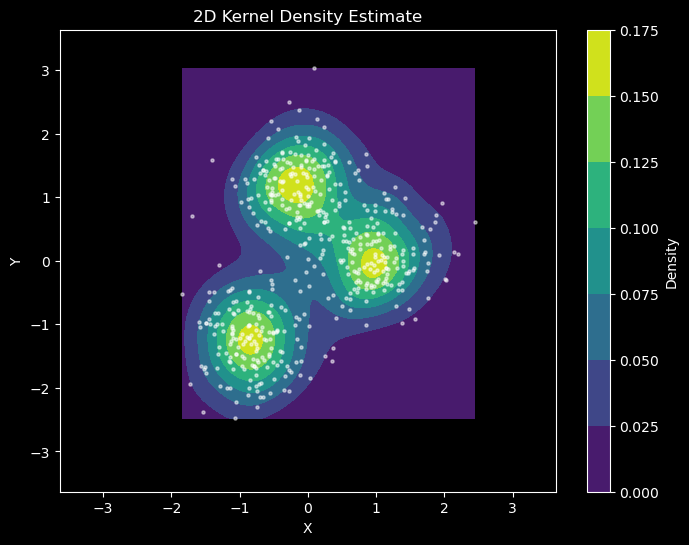

In [14]:
# Calculate the KDE
kde = gaussian_kde(X.T)

# Create a grid over the data range
xmin, xmax = X[:, 0].min(), X[:, 0].max()
ymin, ymax = X[:, 1].min(), X[:, 1].max()
Xgrid, Ygrid = np.meshgrid(
    np.linspace(xmin, xmax, 100),
    np.linspace(ymin, ymax, 100)
)

# Evaluate KDE on the grid
positions = np.vstack([Xgrid.ravel(), Ygrid.ravel()])
Z = kde(positions).reshape(Xgrid.shape)

# Plot the 2D KDE
%matplotlib inline

plt.figure(figsize=(8, 6))
plt.contourf(Xgrid, Ygrid, Z, cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-MAX, MAX)
plt.ylim(-MAX, MAX)
plt.title('2D Kernel Density Estimate')
plt.scatter(X[:, 0], X[:, 1], c='white', s=5, alpha=0.5)  # optional: overlay points
plt.show()


# MeanShift Clustering in-depth

## How Mean Shift Clustering Works (Mathematical Explanation)

Mean Shift is a **mode-seeking algorithm** that iteratively shifts *kernel centers* toward the nearest high-density region.  
**The data points do not move** — they define the density landscape.

---

### 1. Kernel Density Estimate (KDE)

At its core, Mean Shift uses a kernel to estimate the local probability density function (PDF) around each point.

The multivariate KDE at point $\mathbf{x}$ is:

$$
\hat{f}(\mathbf{x}) = \frac{1}{n h^d} \sum_{i=1}^n K\!\Big(\frac{\mathbf{x} - \mathbf{x}_i}{h}\Big)
$$

- $n$ = number of data points  
- $h$ = bandwidth (kernel size)  
- $d$ = number of dimensions  
- $K(\cdot)$ = kernel function (e.g., Gaussian, flat)

---

### 2. The Mean Shift Vector

The **mean shift vector** is the gradient of the density estimate — it points toward the direction of **maximum increase in density**.

At a point $\mathbf{x}$:

$$
\mathbf{m}(\mathbf{x}) = \frac{ \sum_{i=1}^n \mathbf{x}_i \, K\!\Big(\frac{\mathbf{x} - \mathbf{x}_i}{h}\Big) }{ \sum_{i=1}^n K\!\Big(\frac{\mathbf{x} - \mathbf{x}_i}{h}\Big) } - \mathbf{x}
$$

So, it’s the difference between the **weighted mean of nearby points** and the current position.

---

### 3. Iterative Update

Given a starting point $\mathbf{x}^{(t)}$ (the kernel center):

$$
\mathbf{x}^{(t+1)} = \mathbf{x}^{(t)} + \mathbf{m}(\mathbf{x}^{(t)})
$$

Equivalently:

$$
\mathbf{x}^{(t+1)} = \frac{ \sum_{i=1}^n \mathbf{x}_i \, K\!\Big(\frac{\mathbf{x}^{(t)} - \mathbf{x}_i}{h}\Big) }{ \sum_{i=1}^n K\!\Big(\frac{\mathbf{x}^{(t)} - \mathbf{x}_i}{h}\Big) }
$$

This means the kernel center shifts to the **weighted mean** of the data points inside its window.

---

### 4. Convergence

The mean shift process repeats until the shift vector $\mathbf{m}(\mathbf{x})$ is very small:

$$
\|\mathbf{m}(\mathbf{x})\| < \epsilon
$$

for some small threshold $\epsilon$.

## Using Mean Shift Clustering in scikit-learn

**Important Parameters**

**bandwidth**  
The `bandwidth` parameter defines the radius of the kernel window used for shifting. A small bandwidth finds fine-grained clusters, while a large bandwidth merges clusters into larger groups. If you do not specify a bandwidth, scikit-learn can estimate a good starting value automatically using a built-in heuristic.

**bin_seeding**  
This parameter, when set to true, uses an initial coarse grid of seed points rather than starting with every data point. This speeds up convergence, especially for large datasets.

**cluster_all**  
This parameter determines whether all data points must be assigned to a cluster. If true (the default), every point is clustered. If false, points that do not fall within any kernel window are marked as noise and labeled as -1.

**What You Get After Fitting**

After running Mean Shift, the fitted model provides:

- Cluster labels for each sample in the data.
- The coordinates of the cluster centers that represent the detected modes.
- The total number of clusters found by the algorithm.

**Practical Tips**

- The default kernel in scikit-learn’s Mean Shift is a flat kernel.
- Mean Shift can be computationally expensive for large datasets, so using `bin_seeding` or subsampling can help.
- Selecting a good bandwidth is crucial for meaningful clustering results. You can experiment with different values or use scikit-learn’s automatic bandwidth estimation as a starting point.

In [7]:
from sklearn.cluster import MeanShift

bandwidth = 0.4
model = MeanShift(bandwidth=bandwidth)
model.fit(X)
labels = model.predict(X)
labels

array([ 6,  4,  5,  3,  2,  2,  6,  2,  4,  0,  2,  3,  2,  1,  5,  2,  1,
        0,  0,  3,  4,  4,  2,  6,  0,  2,  3,  0,  0,  1,  2,  7,  1,  1,
        2,  2,  2,  4,  0,  0,  4,  3,  1,  3,  3,  5,  2,  2,  2,  0, 12,
        7,  0,  0,  5,  1,  3,  0,  2, 12, 10,  1,  2,  0,  2, 10,  2, 12,
        3,  2,  2,  2,  5,  0,  1, 10,  3,  2,  3,  3,  0,  1,  2,  1,  0,
       12, 10,  4,  2,  3,  0,  5,  3,  2,  2, 12,  7,  1,  7,  0,  2,  1,
        3, 10,  0,  3,  1, 12, 11,  0,  0,  0, 10,  0,  0,  3,  1,  0,  4,
        0,  3,  3,  2,  2,  4,  5,  1,  2,  0,  0,  0,  2,  4,  0,  2,  0,
        0,  0,  4,  1,  0,  6,  5,  2,  0,  0,  0,  1,  3,  3,  2,  0,  2,
        3,  1,  0,  3,  0,  2,  2,  6,  0,  3,  1,  0,  1,  1,  5,  0,  0,
        0,  1,  3,  0,  0,  1,  7,  4,  2,  5,  7,  0,  3,  3,  6,  0,  7,
        5,  3,  0,  0, 10,  0, 12,  1,  2,  1,  1, 10,  2,  1,  3,  4,  0,
        2,  0,  4,  1,  1,  0,  6,  5,  6,  1,  1, 12,  1,  0,  3,  2,  3,
        1,  0,  1,  2,  1

In [16]:
cluster_centers = model.cluster_centers_
cluster_centers

array([[-0.86354095, -1.326061  ],
       [-0.33139893,  1.33954528],
       [ 1.02387768, -0.1972883 ],
       [-0.02637534,  0.84373285],
       [ 0.05953236, -0.12912442],
       [ 1.81220609,  0.60120718],
       [ 0.32694163, -1.48489044],
       [-0.09086994,  2.36435896],
       [ 2.44852211,  0.60995858],
       [ 0.09362858,  3.02832551],
       [-1.29700099, -0.07472043],
       [-1.39865245,  1.58553522],
       [-1.53436077, -2.37455034],
       [-1.69452076,  0.70663063]])

## Visualize decision boundaries

In [17]:
def plot_regions(model, MAX, nGrid=200):
    a1 = np.linspace(-MAX, MAX, nGrid)
    a2 = np.linspace(-MAX, MAX, nGrid)
    A1, A2 = np.meshgrid(a1, a2)
    A = np.vstack([A1.ravel(), A2.ravel()]).T

    B = model.predict(A)
    B = B.reshape(nGrid, nGrid)
    B = np.flipud(B)

    return B

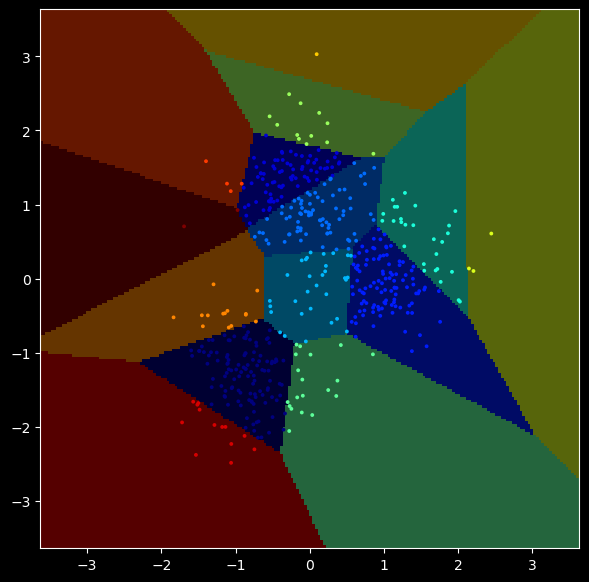

In [19]:
%matplotlib inline
cmap = 'jet'

# Generate decision regions
B = plot_regions(model, MAX)

extent = [-MAX, MAX, -MAX, MAX]

plt.figure(figsize=(7, 7))
plt.imshow(B, interpolation='none', extent=extent, cmap=cmap, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=3, cmap=cmap)

# add cluster centers
# plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='^', s=50, c='m')

plt.xlim(-MAX, MAX)
plt.ylim(-MAX, MAX)
plt.gca().set_aspect('equal')
plt.show()


## Visualize for different bandwidths

In [ ]:
# --------------------------------
# Bandwidths to try
# --------------------------------
bandwidths = np.linspace(0.1, 2, 50)
cmap = 'jet'

# --------------------------------
# Loop with separate figures
# --------------------------------
for bw in bandwidths:
    model = MeanShift(bandwidth=bw)
    labels = model.fit_predict(X)

    # Get number of cluster centers
    n_clusters = model.cluster_centers_.shape[0]

    B = plot_regions(model, MAX)
    extent = [-MAX, MAX, -MAX, MAX]

    plt.figure(figsize=(6, 6))
    plt.imshow(B, interpolation='none', extent=extent, cmap=cmap, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=3, cmap=cmap)
    plt.title(f"MeanShift Clustering\nBandwidth = {bw:.2f} | Clusters = {n_clusters}")
    plt.xlim(-MAX, MAX)
    plt.ylim(-MAX, MAX)
    plt.gca().set_aspect('equal')
    plt.show()

## Using `estimate_bandwidth`

This function calculates the pairwise distances of all (or a random subsample) of points and outputs a given quantile (default 0.3).

In [8]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X, quantile=0.25)
bandwidth

0.9799599021288825

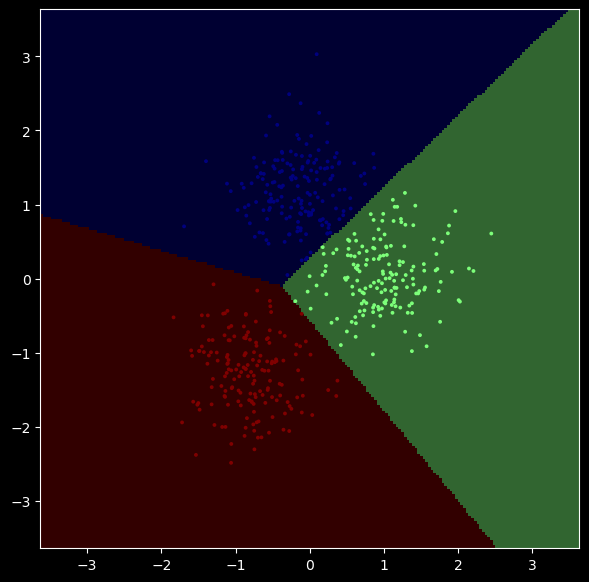

In [22]:
model = MeanShift(bandwidth=bandwidth)
model.fit(X)
labels = model.predict(X)

%matplotlib inline
cmap = 'jet'

# Generate decision regions
B = plot_regions(model, MAX)

extent = [-MAX, MAX, -MAX, MAX]

plt.figure(figsize=(7, 7))
plt.imshow(B, interpolation='none', extent=extent, cmap=cmap, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=3, cmap=cmap)
# Optional: add cluster centers if they exist
# plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='^', s=50, c='w')

plt.xlim(-MAX, MAX)
plt.ylim(-MAX, MAX)
plt.gca().set_aspect('equal')
plt.show()